In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from transformers import ViTForImageClassification
import torchvision.models as tvm
import numpy as np

import sys; sys.path.append("../src/")
from models import SmoothMaskedImageClassifier
from data_utils import load_images_from_directory

torch.manual_seed(1234)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
run_stuff = True
overwrite_cache = True

In [3]:
images = load_images_from_directory("/home/antonxue/foo/imagenet-sample-images/").to(device)
print(images.shape)

torch.Size([1000, 3, 224, 224])


In [4]:
lambdas = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.25, 0.2, 0.1]
print(lambdas)

[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.25, 0.2, 0.1]


In [5]:
accs = []

In [6]:
if run_stuff:
    for lambda_ in lambdas:
        smooth_model = SmoothMaskedImageClassifier(
            # ViTForImageClassification.from_pretrained("google/vit-base-patch16-224"),
            tvm.resnet18(weights=tvm.ResNet18_Weights.IMAGENET1K_V1),
            num_samples = 64,
            lambda_ = lambda_
        ).eval().to(device)
    
        hits, num_dones = 0, 0
        pbar = tqdm(images)
        with torch.no_grad():
            for class_id, image in enumerate(pbar):
                out = smooth_model(image[None,...])
                hits += (out.argmax(dim=-1) == class_id).item()
                num_dones += 1
                pbar.set_description(f"lambda {lambda_:.3f}, acc {(hits/num_dones):.3f}")
        accs.append(hits/num_dones)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
if overwrite_cache and len(accs) > 0:
    torch.save({"lambdas":lambdas, "accs":accs}, "_cache/resnet_accuracy_vs_lambda.pt")

In [8]:
# accs = torch.load("_cache/roberta_accuracy_vs_lambda.pt")["accs"]

<Figure size 640x480 with 0 Axes>

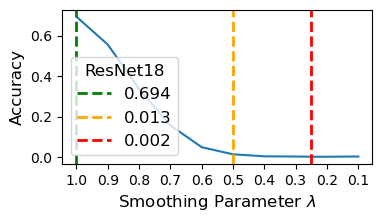

In [11]:
fs = 12
plt.clf()
fig, ax = plt.subplots(figsize=(4,2))
ax.plot(lambdas, accs)
plt.gca().invert_xaxis()

ax.set_xticks([1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])
ax.set_ylabel("Accuracy", fontsize=fs)
ax.set_xlabel("Smoothing Parameter $\lambda$", fontsize=fs)

ax.tick_params(axis="both", labelsize=fs-2)
ax.axvline(x=1.0, color="green", linestyle="--", linewidth=2, label=f"{accs[0]:.3f}")
ax.axvline(x=0.5, color="orange", linestyle="--", linewidth=2, label=f"{accs[5]:.3f}")
ax.axvline(x=0.25, color="red", linestyle="--", linewidth=2, label=f"{accs[7]:.3f}")

ax.legend(title="ResNet18", loc="lower left", title_fontsize=fs, fontsize=fs)
plt.savefig("../figures/resnet_accuracy_vs_lambda.pdf", bbox_inches="tight")